In [1]:
import sys
import os
import copy
import traceback

########################
# Find qslam modules
########################
sys.path.append('../qslam')
sys.path.append('../paduaq')

from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import CreateNaiveExpt as risknaive
from riskanalysis import EngineeredTruth
from visualiserisk import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from randpoly import NEARESTPADUA
from pdinter_MM import pd_interpolant, calc_padua_cgl
from true_functions import true_function, generate_data_qubits_coords
from pdpoints import dims_padua_set

sys.path.append('./')

In [2]:
def get_keys(padua_order, true_function_type, polyorder_=False):

    if padua_order > 0:
        prefix = true_function_type +'_padua_ord_'+str(padua_order)+'_'
        polyorder = padua_order

    if padua_order == -1: 
        prefix = true_function_type +'_no_padua_'
        padua_order = "no_padua"

    if padua_order == -2:
        prefix = true_function_type +'_regfine_'
        padua_order = "regfine"
        polyorder = 9

    if padua_order == -3:
        prefix = true_function_type +'_regcoarse_'
        padua_order = "regcoarse"
        polyorder = 4

    if padua_order == -4:
        prefix = true_function_type +'_reg4_'
        padua_order = "reg4"
        polyorder = 1

    if padua_order == -5:
        prefix = true_function_type +'_reg9_'
        padua_order = "reg9"
        polyorder = 3

    if padua_order == -6:
        prefix = true_function_type +'_reg36_'
        padua_order = "reg36"
        polyorder = 7

    if padua_order == -7:
        prefix = true_function_type +'_reg25_'
        padua_order = "reg25"
        polyorder = 6
        
    if true_function_type == 'randpolymax':
        REGGRID=81
        prefix = true_function_type +'_reg_'+str(REGGRID)+'_'+'ord_'+str(padua_order)+'_' 
        polyorder = padua_order

    if polyorder_:
        return polyorder
    
    if not polyorder_:
        return prefix, padua_order

In [3]:
########################
# Analysis parameters
########################

INFTYPE = 'expinf'
# SSIM
# Default Cone Ctwo too large for this application of ssim score. Decrease by factor of 100. 
Cone=0.000001
Ctwo=0.000001

data_qubit_num = 25
data_qubit_flag ='uniform'
TUNING_MULTIPLIER=5
trials=50

########################
# Save/Load to path 
########################

PATHDICT['pdir'] = './data/' # load path

if INFTYPE == 'expinf':
    save_to_path = './data_expinf'
    INFTYPE = 'expinf_' # hack to compute std in inf scores

if INFTYPE == 'maxinf':
    save_to_path = './data_maxinf'


Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]
max_msmtvar = len(Multiples)

In [4]:
PLOT_DICT ={}
PLOT_DICT['label'] = ''
PLOT_DICT['marker'] = ''
PLOT_DICT['ls'] = ''
PLOT_DICT['color'] = 'white'
PLOT_DICT['markerfacecolor'] = 'None'
PLOT_DICT['ms'] = 4
PLOT_DICT['alpha'] = 0.75
PLOT_DICT['capsize'] = 2
PLOT_DICT['elinewidth'] = 0.8
PLOT_DICT['markeredgewidth'] = 0.8
PLOT_DICT['lw'] = 1.0

RBF = copy.deepcopy(PLOT_DICT)
RBF['marker'] = 's'
RBF['label'] = 'Regular grid'
RBF['color'] = 'steelblue'
RBF['alpha'] = 1.
RBF['ms'] = 4
RBF['markerfacecolor'] = 'lightsteelblue'

RBFmax = copy.deepcopy(PLOT_DICT)
RBFmax['marker'] = 'H'
RBFmax['label'] = 'Max regular grid'
RBFmax['color'] = 'darkgreen'
RBFmax['alpha'] = 0.7
RBFmax['ls'] = '-.'
RBFmax['ms'] = 5

LAGR = copy.deepcopy(PLOT_DICT)
LAGR['marker'] = '^'
LAGR['label'] = 'Padua grid'
LAGR['color'] = 'k'
LAGR['ls'] = '--'
LAGR['alpha'] = 0.7
LAGR['markerfacecolor'] = 'k'

In [5]:
################################################
# RANDOM POLYNOMIAL ANALYSIS WITH MATCHED RBF
################################################

SIM_DICT_LABELS =['randpoly']
SIM_DICT_LIST = [ None ]

# RANDOM POLYNOMIAL FUNCTIONALITY FUDGE: replace -1 with -2, 5 replaced with 7, 10 replaced with 9
GRID_ORDER = [-4, -5, -3, -7, -2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
POLY_ORDER = [get_keys(idx, 'randpoly', polyorder_=True) for idx in GRID_ORDER]
PICK_PADUA_ORDER=5
REG_SCALING = np.asarray([4, 9, 16, 25, 56])
PADUA_ORDER = np.asarray(GRID_ORDER[PICK_PADUA_ORDER:])
NUM_SENSOR_QUBITS = [dims_padua_set(idx_order)for idx_order in PADUA_ORDER]


data_labels=['naive_inf']
naive_inf = []

for idx_case in range(len(SIM_DICT_LIST)):
    
    SIMULATIONSDICT = SIM_DICT_LIST[idx_case]
    
    for idx_grid in range(len(GRID_ORDER)):
        
        prefix, padua_order = get_keys(GRID_ORDER[idx_grid], SIM_DICT_LABELS[idx_case])


        fname_likelihood = 'interpol_only'# 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)

        for idx_msmt_var in Multiples:

            unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var) 
            PATHDICT["fle"] = unique_ID
            
            naivedata = np.load(path_to_file(PATHDICT, flag='n'))
            naive_inf.append(Metric.infnorm(naivedata["macro_residuals"], e_type=INFTYPE))
    
for dataset in data_labels:
    vars()[dataset] = np.asarray(vars()[dataset]).reshape(len(SIM_DICT_LIST), len(GRID_ORDER), len(Multiples), trials)

for dataset in data_labels:
    
    vars()[dataset+'_exp_loss'] = np.nanmean(vars()[dataset], axis=3)
    vars()[dataset+'_std_loss'] = np.nanstd(vars()[dataset], axis=3)
    vars()[dataset+'_errbar_upp'] = vars()[dataset+'_exp_loss'] + vars()[dataset+'_std_loss']
    vars()[dataset+'_errbar_low'] = vars()[dataset+'_exp_loss'] - vars()[dataset+'_std_loss']



In [6]:
################################################
# RANDOM POLYNOMIAL ANALYSIS WITH MATCHED RBF
################################################

SIM_DICT_LABELS =['randpolymax']
SIM_DICT_LIST = [ None ]

# RANDOM POLYNOMIAL FUNCTIONALITY FUDGE: replace -1 with -2, 5 replaced with 7, 10 replaced with 9
MAX_GRID_ORDER = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MAX_POLY_ORDER = [get_keys(idx, 'randpolymax', polyorder_=True) for idx in MAX_GRID_ORDER]

data_labels=['max_naive_inf']
max_naive_inf = []

for idx_case in range(len(SIM_DICT_LIST)):
    
    SIMULATIONSDICT = SIM_DICT_LIST[idx_case]
    
    for idx_grid in range(len(MAX_GRID_ORDER)):
        
        prefix, padua_order = get_keys(MAX_GRID_ORDER[idx_grid], SIM_DICT_LABELS[idx_case])

        fname_likelihood = 'interpol_only'# 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)

        for idx_msmt_var in Multiples:

            unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var) 
            PATHDICT["fle"] = unique_ID
            
            # RANDOM POLYNOMIAL FUNCTIONALITY 
            max_naivedata = np.load(path_to_file(PATHDICT, flag='n'))
            max_naive_inf.append(Metric.infnorm(max_naivedata["macro_residuals"], e_type=INFTYPE))
    
for dataset in data_labels:
    vars()[dataset] = np.asarray(vars()[dataset]).reshape(len(SIM_DICT_LIST), len(MAX_GRID_ORDER), len(Multiples), trials)

for dataset in data_labels:
    
    vars()[dataset+'_exp_loss'] = np.nanmean(vars()[dataset], axis=3)
    vars()[dataset+'_std_loss'] = np.nanstd(vars()[dataset], axis=3)
    vars()[dataset+'_errbar_upp'] = vars()[dataset+'_exp_loss'] + vars()[dataset+'_std_loss']
    vars()[dataset+'_errbar_low'] = vars()[dataset+'_exp_loss'] - vars()[dataset+'_std_loss']



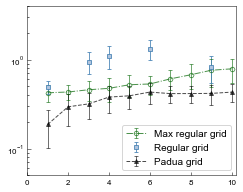

In [7]:
dataset_naive = 'naive_inf'
dataset_qslam = 'qslam_inf'
dataset_simpa = 'simpassgn_inf'

idx_msmt_var = len(Multiples) - 1

# Main text figure ratios
fig, axes = plt.subplots(1, 1, figsize=(cm2inch(9.5), cm2inch(7.9))) 


idx_truth=0
ax1 = axes

ax1.errorbar(np.asarray(MAX_POLY_ORDER), vars()['max_'+dataset_naive+'_exp_loss'][idx_truth,:, idx_msmt_var],
         yerr=vars()['max_'+dataset_naive +'_std_loss'][idx_truth, :, idx_msmt_var], **RBFmax)


ax1.errorbar(np.asarray(POLY_ORDER)[0:PICK_PADUA_ORDER], vars()[dataset_naive+'_exp_loss'][idx_truth,0:PICK_PADUA_ORDER, idx_msmt_var],
         yerr=vars()[dataset_naive +'_std_loss'][idx_truth, 0:PICK_PADUA_ORDER, idx_msmt_var], **RBF)

ax1.errorbar(np.asarray(POLY_ORDER)[PICK_PADUA_ORDER:], 
             vars()[dataset_naive+'_exp_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var],
             yerr=vars()[dataset_naive+'_std_loss'][idx_truth, PICK_PADUA_ORDER :, idx_msmt_var], **LAGR)

ax1.set_yscale('log')
ax1.set_ylim([0.05, 4])
ax1.set_xlim([0, 10.2])
ax1.legend(loc=0)

plt.savefig('FIGURES/padua_vs_rbf_SD.svg', format='svg', dpi=900)
plt.show()

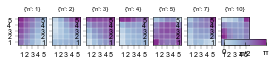

In [8]:
TRUTHKWARGS = {}
TRUTHKWARGS["truthtype"] = "UseFunction"
TRUTHKWARGS["true_function"] = true_function
TRUTHKWARGS["true_function_type"] = 'randpoly'
TRUTHKWARGS["randpoly"]={}

data_qubits = generate_data_qubits_coords(data_qubit_num, flag=data_qubit_flag)

ORDERS = [1, 2, 3, 4, 5, 7,10]# GRID_ORDER[PICK_PADUA_ORDER:]

fig, ax = plt.subplots(1,7, figsize=(cm2inch(1.5)*7, cm2inch(1.5)))

for idx in range(len(ORDERS)):
    
    padua_order = ORDERS[idx]
    
    TRUTHKWARGS["randpoly"]["n"]= padua_order
    
    sensing_qubits = calc_padua_cgl(padua_order)[0]
    TRUTHKWARGS["all_qubit_locations"] = sensing_qubits + data_qubits
    num_of_nodes = len(TRUTHKWARGS["all_qubit_locations"])
    
    true_map_ =  EngineeredTruth(num_of_nodes, TRUTHKWARGS).get_map()
    
    
    ax[idx].set_title(TRUTHKWARGS['randpoly'], fontsize=6)
    im1 = ax[idx].imshow(true_map_[len(sensing_qubits):].reshape(5,5), **HEATMAP)
    
    # Show all ticks...
    ax[idx].set_xticks(np.arange(5), minor=True)
    ax[idx].set_yticks(np.arange(5), minor=True)

    # Make a grid and put labels on the center
    axis_list = [ax[idx].yaxis, ax[idx].xaxis]
    for idx_axis in range(2):

        labels = range(1, 5 + 1, 1)
        locs = np.arange(len(labels))

        axis = axis_list[idx_axis]
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)

    # Make the grid white
    ax[idx].grid(which="minor", color="w", linestyle='-', linewidth=0.25)
    ax[idx].tick_params(axis='both', which='both', color='w', labelsize=7, width=0.25)
    ax[idx].tick_params(axis='both', which='major', color='k', direction='out',width=0.25)

    
axins = inset_axes(ax[-1],
                   width="150%",  # width of parent_bbox width
                   height="20%",  # height
                   loc='lower left',
                   bbox_to_anchor=(0.1, 0., 1, 1),
                   bbox_transform=ax[-1].transAxes,
                   borderpad=0,
                   )

cbar = fig.colorbar(im1, cax=axins, ticks=[0, np.pi/2 , np.pi], orientation='horizontal')
cbar.ax.set_xticklabels(['0',r'$\pi/2$', r'$\pi$'])
    
plt.savefig('./FIGURES/randpoly_orders.svg', format='svg', dpi=900)
    
plt.show()